In [2]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path

# Read data

In [248]:
link='/Users/andreza/reproducibility_transportation_hubs-early_warning_surveillance_systems/data/hub_pop_density.csv'
data = pd.read_csv(link)

In [249]:
data.columns

Index(['Código Município Completo', '_c0', 'UF2', 'Nome_UF',
       'Mesorregião Geográfica', 'Nome_Mesorregião', 'Microrregião Geográfica',
       'Nome_Microrregião', 'Município', 'Nome_Município', 'uf10', 'co_uf',
       'nm_municipio', 'ind_proxi', 'ind_intermed', 'ind_proxi_per',
       'ind_intermed_per', 'grau', 'densidade_2022', 'populacao_2022', 'key',
       'UF', 'co_munic', 'NOME DO MUNICÍPIO', 'POPULAÇÃO ESTIMADA 2020',
       'POPULAÇÃO ESTIMADA 2019', 'POPULAÇÃO ESTIMADA 2018',
       'POPULAÇÃO ESTIMADA 2017', 'POPULAÇÃO ESTIMADA 2016',
       'POPULAÇÃO ESTIMADA 2015', 'POPULAÇÃO ESTIMADA 2014',
       'POPULAÇÃO ESTIMADA 2013', 'POPULAÇÃO ESTIMADA 2012',
       'POPULAÇÃO ESTIMADA 2011', 'co_ibge'],
      dtype='object')

In [250]:
data.head()

,Código Município Completo,_c0,UF2,Nome_UF,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Nome_Município,...,POPULAÇÃO ESTIMADA 2019,POPULAÇÃO ESTIMADA 2018,POPULAÇÃO ESTIMADA 2017,POPULAÇÃO ESTIMADA 2016,POPULAÇÃO ESTIMADA 2015,POPULAÇÃO ESTIMADA 2014,POPULAÇÃO ESTIMADA 2013,POPULAÇÃO ESTIMADA 2012,POPULAÇÃO ESTIMADA 2011,co_ibge
0,1302108,105,13,Amazonas,1,Norte Amazonense,2,Japurá,2108,Japurá,...,2755,3265,4205,4660,5125,5599,6083,7448.0,7388.0,1302108
1,1502954,197,15,Pará,6,Sudeste Paraense,19,Parauapebas,2954,Eldorado do Carajás,...,33808,33674,32892,32780,32664,32544,32420,32115.0,31953.0,1502954
2,1702554,327,17,Tocantins,1,Ocidental do Tocantins,1,Bico do Papagaio,2554,Augustinópolis,...,18412,18178,18089,17861,17627,17386,17140,16401.0,16179.0,1702554
3,2104073,519,21,Maranhão,5,Sul Maranhense,20,Gerais de Balsas,4073,Feira Nova do Maranhão,...,8504,8481,8372,8347,8321,8293,8263,8215.0,8171.0,2104073
4,2108207,587,21,Maranhão,3,Centro Maranhense,10,Médio Mearim,8207,Pedreiras,...,39229,39267,38365,38433,38506,38582,39337,39391.0,39419.0,2108207


In [251]:
data = data[['Nome_UF','UF2','co_ibge','Nome_Município', 'ind_proxi', 'ind_intermed', 'ind_proxi_per',
       'ind_intermed_per', 'grau', 'densidade_2022', 'populacao_2022']]

In [252]:
data = data.fillna(0)

In [253]:
data.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022
0,Amazonas,13,1302108,Japurá,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858
1,Pará,15,1502954,Eldorado do Carajás,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192
2,Tocantins,17,1702554,Augustinópolis,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484
3,Maranhão,21,2104073,Feira Nova do Maranhão,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050


In [254]:
data = data.assign(ones = 1)

# Proximity index

## Distribution of PI

In [255]:
data[['ind_proxi','grau']].describe().round(2)

,ind_proxi,grau
count,5570.00,5570.00
mean,0.31,23.60
std,0.07,45.95
min,0.00,0.00
25%,0.29,4.00
50%,0.31,11.00
75%,0.36,24.00
max,0.56,1477.00


## Create category to define hubs and non hubs by PI criterium

In [256]:
data.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones
0,Amazonas,13,1302108,Japurá,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858,1
1,Pará,15,1502954,Eldorado do Carajás,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192,1
2,Tocantins,17,1702554,Augustinópolis,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484,1
3,Maranhão,21,2104073,Feira Nova do Maranhão,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048,1
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1


In [257]:
data[(data.ind_proxi >= 0.36) & (data.Nome_UF == 'Acre') ]

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones
736,Acre,12,1200401,Rio Branco,0.398500,0.010125,39.850011,1.012517,73.0,41.28,364756,1
1787,Acre,12,1200500,Sena Madureira,0.372202,0.000765,37.220162,0.076537,10.0,1.74,41349,1


In [258]:
data[(data.ind_proxi >= 0.36) & (data.Nome_UF == 'Amazonas') ]

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones


In [259]:
data[(data.ind_intermed >= 0.000053) & (data.Nome_UF == 'Acre') ]

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones
736,Acre,12,1200401,Rio Branco,0.398500,0.010125,39.850011,1.012517,73.0,41.28,364756,1
1787,Acre,12,1200500,Sena Madureira,0.372202,0.000765,37.220162,0.076537,10.0,1.74,41349,1
2047,Acre,12,1200203,Cruzeiro do Sul,0.285458,0.001851,28.545847,0.185100,11.0,10.46,91888,1


In [260]:
data.loc[(data['ind_proxi'] < 0.36),'hub_ind_proxi'] = 0

data.loc[(data['ind_proxi'] >= 0.36),'hub_ind_proxi'] = 1

In [261]:
cutPI = data[data.hub_ind_proxi == 1]#.sort_values(by=['ind_proxi'],ascending=False)

In [262]:
cutPI.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones,hub_ind_proxi
9,Bahia,29,2926301,Riachão do Jacuípe,0.376729,0.000247,37.672899,0.024668,49.0,28.90,33386,1,1.0
13,Minas Gerais,31,3145604,Oliveira,0.377332,0.000391,37.733222,0.039079,37.0,43.76,39262,1,1.0
16,São Paulo,35,3502507,Aparecida,0.409026,0.001391,40.902573,0.139059,114.0,269.41,32569,1,1.0
17,São Paulo,35,3503158,Arapeí,0.361357,0.000039,36.135742,0.003938,12.0,14.85,2330,1,1.0
29,Pará,15,1506609,Santa Maria do Pará,0.392867,0.001238,39.286750,0.123780,93.0,53.80,24624,1,1.0


## Number of hubs by state given by PI

In [263]:
data[data.ind_proxi >= 0.36].groupby(['Nome_UF'])['ones'].count()
#não temos o estado do amazonas com este recorte, apenas 24 UFs selecionadas

Nome_UF
Acre                     2
Alagoas                 22
Bahia                  182
Ceará                   59
Distrito Federal         1
Espírito Santo          15
Goiás                   39
Maranhão                25
Mato Grosso             39
Mato Grosso do Sul      26
Minas Gerais           259
Paraná                 101
Paraíba                 48
Pará                    14
Pernambuco              67
Piauí                   68
Rio Grande do Norte     12
Rio Grande do Sul       45
Rio de Janeiro          30
Rondônia                 9
Santa Catarina          53
Sergipe                 17
São Paulo              353
Tocantins               13
Name: ones, dtype: int64

In [264]:
# cutPI[cutPI['Nome_UF'] == 'Acre']

In [265]:
# import seaborn as sns
# from fitter import Fitter, get_common_distributions, get_distributions

# # https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

# f = Fitter(data['ind_proxi'],
#           distributions=['gamma',
#                          'lognorm',
#                          "beta",
#                          "burr",
#                          "norm"])
# f.fit()
# f.summary()


# Example 1: Plot distribution of values in Marks column
# data['ind_proxi'].plot(kind='kde')
# f.get_best(method = 'sumsquare_error')

# Betweenness index

## Distribution of BI

In [266]:
data['ind_intermed'].describe()#*100

count    5570.000000
mean        0.000384
std         0.004374
min         0.000000
25%         0.000000
50%         0.000002
75%         0.000053
max         0.283094
Name: ind_intermed, dtype: float64

## Create category to define hus and non hubs by BI criterium

In [267]:
data.loc[(data['ind_intermed'] < 0.000053),'hub_ind_intermed'] = 0

data.loc[(data['ind_intermed'] >= 0.000053),'hub_ind_intermed'] = 1

In [268]:
cutII = data[data.hub_ind_intermed == 1]

## Number of hubs by state given by BI

In [269]:
#data[data.ind_intermed >= 0.000053]
cutII.groupby(['Nome_UF'])['ones'].count()

Nome_UF
Acre                     3
Alagoas                 17
Amapá                    1
Amazonas                 5
Bahia                  108
Ceará                   54
Distrito Federal         1
Espírito Santo          25
Goiás                   47
Maranhão                50
Mato Grosso             53
Mato Grosso do Sul      28
Minas Gerais           227
Paraná                 104
Paraíba                 44
Pará                    35
Pernambuco              60
Piauí                   53
Rio Grande do Norte     17
Rio Grande do Sul      110
Rio de Janeiro          27
Rondônia                13
Roraima                  2
Santa Catarina          77
Sergipe                 16
São Paulo              190
Tocantins               24
Name: ones, dtype: int64

In [270]:
#cutII.sort_values(by=['ind_intermed'],ascending=False)

In [271]:
#cutII['Nome_UF'].unique()
cutII.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones,hub_ind_proxi,hub_ind_intermed
1,Pará,15,1502954,Eldorado do Carajás,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192,1,0.0,1.0
2,Tocantins,17,1702554,Augustinópolis,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484,1,0.0,1.0
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1,0.0,1.0
7,Paraíba,25,2517001,Umbuzeiro,0.314568,0.000081,31.456761,0.008081,15.0,49.17,9124,1,0.0,1.0
9,Bahia,29,2926301,Riachão do Jacuípe,0.376729,0.000247,37.672899,0.024668,49.0,28.90,33386,1,1.0,1.0


# Density

## Distribution of density

In [272]:
data['densidade_2022'].describe()#*100

count     5570.000000
mean       116.028815
std        595.755683
min          0.150000
25%         11.340000
50%         24.290000
75%         53.605000
max      13416.810000
Name: densidade_2022, dtype: float64

## Create category to define hubs and non hubs by Density criterium

In [273]:
data.loc[(data['densidade_2022'] < 53.605000),'hub_density'] = 0

data.loc[(data['densidade_2022'] >= 53.605000),'hub_density'] = 1
cutIII = data[data.hub_density == 1]

In [274]:
cutIII.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones,hub_ind_proxi,hub_ind_intermed,hub_density
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1,0.0,1.0,1.0
6,Paraíba,25,2515005,São Miguel de Taipu,0.305593,0.000001,30.559314,0.000123,5.0,76.46,7066,1,0.0,0.0,1.0
16,São Paulo,35,3502507,Aparecida,0.409026,0.001391,40.902573,0.139059,114.0,269.41,32569,1,1.0,1.0,1.0
18,São Paulo,35,3507803,Brodowski,0.319707,0.000000,31.970743,0.000000,2.0,90.50,25201,1,0.0,0.0,1.0
20,Paraná,41,4112405,Japurá,0.283577,0.000000,28.357662,0.000000,2.0,55.36,9144,1,0.0,0.0,1.0


## Number of hubs by state given by Density

In [275]:
cutIII.groupby(['Nome_UF'])['ones'].count()
#25 UFs incluidas, Acre e Rondonia não aparece

Nome_UF
Alagoas                 65
Amapá                    2
Amazonas                 1
Bahia                   80
Ceará                   69
Distrito Federal         1
Espírito Santo          28
Goiás                   22
Maranhão                22
Mato Grosso              2
Mato Grosso do Sul       4
Minas Gerais           158
Paraná                  79
Paraíba                 89
Pará                    16
Pernambuco             123
Piauí                    8
Rio Grande do Norte     55
Rio Grande do Sul      109
Rio de Janeiro          67
Roraima                  1
Santa Catarina          92
Sergipe                 41
São Paulo              257
Tocantins                2
Name: ones, dtype: int64

# Analysis of PI and BI

## Count the number of municipalities by state that are hubs with both indexes

In [276]:
# for value in cutII['Nome_UF'].unique():
#     print(value, len(list(set(cutII[cutII['Nome_UF'] == value].nm_municipio) 
#                           & set(cutPI[cutPI['Nome_UF'] == value].nm_municipio))))

## Hubs of commun hubs

In [277]:
data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 1)),'hub_inter'] = 1
data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 0)),'hub_inter'] = 1
#aqui não deveria incluir intermed=0 & proxi=1??? Fiz em seguida

In [278]:
data.hub_inter = data.hub_inter.fillna(0)

In [279]:
data[['Nome_UF','co_ibge','Nome_Município','hub_ind_proxi','hub_ind_intermed', 'hub_inter']].to_csv('/Users/andreza/reproducibility_transportation_hubs-early_warning_surveillance_systems/data/lists_of_hubs.csv')

In [280]:
data.to_csv('/Users/andreza/reproducibility_transportation_hubs-early_warning_surveillance_systems/data/lists_of_hubs.csv')

In [281]:
data.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones,hub_ind_proxi,hub_ind_intermed,hub_density,hub_inter
0,Amazonas,13,1302108,Japurá,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858,1,0.0,0.0,0.0,0.0
1,Pará,15,1502954,Eldorado do Carajás,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192,1,0.0,1.0,0.0,1.0
2,Tocantins,17,1702554,Augustinópolis,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484,1,0.0,1.0,0.0,1.0
3,Maranhão,21,2104073,Feira Nova do Maranhão,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048,1,0.0,0.0,0.0,0.0
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1,0.0,1.0,1.0,1.0


In [349]:
data_all=data

In [350]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nome_UF           5570 non-null   object 
 1   UF2               5570 non-null   int64  
 2   co_ibge           5570 non-null   int64  
 3   Nome_Município    5570 non-null   object 
 4   ind_proxi         5570 non-null   float64
 5   ind_intermed      5570 non-null   float64
 6   ind_proxi_per     5570 non-null   float64
 7   ind_intermed_per  5570 non-null   float64
 8   grau              5570 non-null   float64
 9   densidade_2022    5570 non-null   float64
 10  populacao_2022    5570 non-null   int64  
 11  ones              5570 non-null   int64  
 12  hub_ind_proxi     5570 non-null   float64
 13  hub_ind_intermed  5570 non-null   float64
 14  hub_density       5570 non-null   float64
 15  hub_inter         5570 non-null   float64
dtypes: float64(10), int64(4), object(2)
memory

In [363]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Definir o estilo do gráfico
# sns.set(style="ticks")

# # Plotar o gráfico de dispersão hue='densidade_2022',
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=data_all, x='ind_proxi', y='ind_intermed', palette='viridis')
# plt.title('Scatter Plot - ind_proxi vs densidade_2022')
# plt.xlabel('ind_proxi')
# plt.ylabel('ind_intermed')
# # plt.legend(title='densidade_2022')
# plt.grid(True)
# plt.show()

In [364]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Definir o estilo do gráfico
# sns.set(style="ticks")

# # Plotar o gráfico de dispersão 
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=hub_data, x='ind_proxi', y='ind_intermed', hue='densidade_2022',palette='viridis')
# plt.title('Scatter Plot - ind_proxi vs densidade_2022')
# plt.xlabel('ind_proxi')
# plt.ylabel('ind_intermed')
# # plt.legend(title='densidade_2022')
# plt.grid(True)
# plt.show()

# Correlations and countings of hubs and non hubs

In [282]:
data.hub_inter.value_counts()

0.0    4179
1.0    1391
Name: hub_inter, dtype: int64

In [283]:
# #including intermed=0 & proxi=1
# data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 1)),'hub_inter'] = 1
# data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 0)),'hub_inter'] = 1
# #data.loc[((data['hub_ind_intermed'] == 0)&(data['hub_ind_proxi'] == 1)),'hub_inter'] = 1

In [284]:
# data.hub_inter = data.hub_inter.fillna(0)

In [285]:
# data.hub_inter.value_counts()
#aumenta o número de hub_inter

# Selecting only hub candidate cities (within 75% +) by BI, PI and Density

In [294]:
#including density hubs
data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 1)),'hub_inter'] = 1
data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 0)),'hub_inter'] = 1
data.loc[((data['hub_ind_intermed'] == 0)&(data['hub_ind_proxi'] == 1)),'hub_inter'] = 1
data.loc[((data['hub_ind_intermed'] == 0)&(data['hub_density'] == 1)),'hub_inter'] = 1
data.loc[((data['hub_ind_proxi'] == 0)&(data['hub_density'] == 1)),'hub_inter'] = 1



In [295]:
data.hub_inter.value_counts()

0.0    3063
1.0    2507
Name: hub_inter, dtype: int64

In [300]:
hub_data = data[(data.hub_inter==1)]
hub_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507 entries, 1 to 5569
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nome_UF           2507 non-null   object 
 1   UF2               2507 non-null   int64  
 2   co_ibge           2507 non-null   int64  
 3   Nome_Município    2507 non-null   object 
 4   ind_proxi         2507 non-null   float64
 5   ind_intermed      2507 non-null   float64
 6   ind_proxi_per     2507 non-null   float64
 7   ind_intermed_per  2507 non-null   float64
 8   grau              2507 non-null   float64
 9   densidade_2022    2507 non-null   float64
 10  populacao_2022    2507 non-null   int64  
 11  ones              2507 non-null   int64  
 12  hub_ind_proxi     2507 non-null   float64
 13  hub_ind_intermed  2507 non-null   float64
 14  hub_density       2507 non-null   float64
 15  hub_inter         2507 non-null   float64
dtypes: float64(10), int64(4), object(2)
memory

In [336]:
# # Calcular a matriz de correlação
# correlation_matrix = hub_data[['ind_proxi', 'densidade_2022', 'ind_intermed']].corr()

# # Plotar o heatmap da matriz de correlação
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
# plt.title('Correlation Heatmap')
# plt.show()

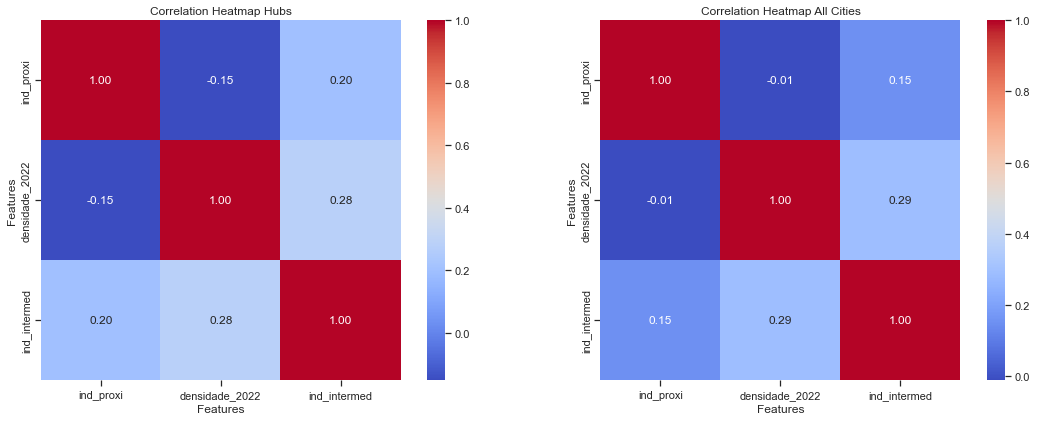

In [351]:
# # Calcular a matriz de correlação com todos os municipios
# correlation_matrix = data[['ind_proxi', 'densidade_2022', 'ind_intermed']].corr()

# # Plotar o heatmap da matriz de correlação
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
# plt.title('Correlation Heatmap All Cities')
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de correlação para hub_data
correlation_matrix_hub = hub_data[['ind_proxi', 'densidade_2022', 'ind_intermed']].corr()

# Calcular a matriz de correlação para todos os municípios
correlation_matrix_all = data_all[['ind_proxi', 'densidade_2022', 'ind_intermed']].corr()

# Criar uma nova figura e eixos (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o heatmap da matriz de correlação para hub_data
sns.heatmap(correlation_matrix_hub, annot=True, cmap='coolwarm', fmt=".2f", square=True, ax=axs[0])
axs[0].set_title('Correlation Heatmap Hubs')
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Features')

# Plotar o heatmap da matriz de correlação para todos os municípios
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", square=True, ax=axs[1])
axs[1].set_title('Correlation Heatmap All Cities')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Features')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os dois heatmaps de correlação
plt.show()

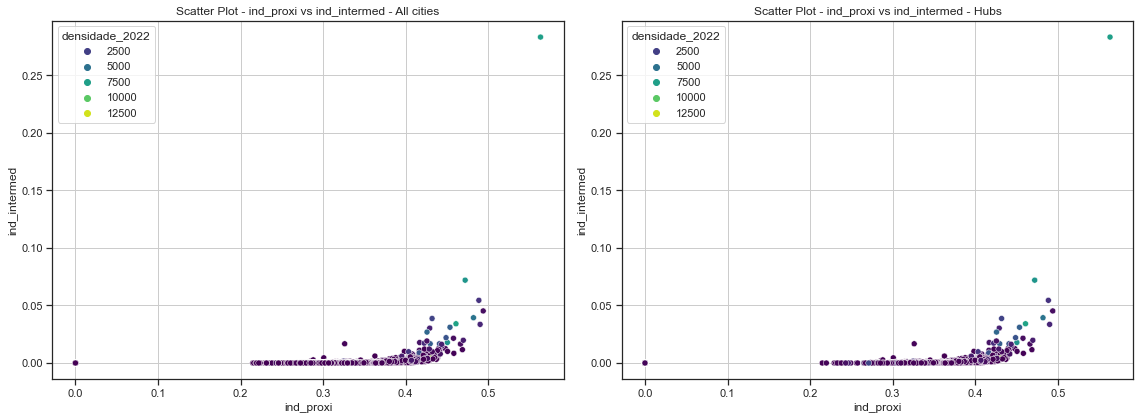

In [353]:
# Definir o estilo do gráfico
sns.set(style="ticks")

# Criar uma nova figura e eixos (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o primeiro gráfico de dispersão
sns.scatterplot(data=data_all, x='ind_proxi', y='ind_intermed', hue='densidade_2022', palette='viridis', ax=axs[0])
axs[0].set_title('Scatter Plot - ind_proxi vs ind_intermed - All cities')
axs[0].set_xlabel('ind_proxi')
axs[0].set_ylabel('ind_intermed')
axs[0].legend(title='densidade_2022')
axs[0].grid(True)

# Plotar o segundo gráfico de dispersão
sns.scatterplot(data=hub_data, x='ind_proxi', y='ind_intermed', hue='densidade_2022', palette='viridis', ax=axs[1])
axs[1].set_title('Scatter Plot - ind_proxi vs ind_intermed - Hubs')
axs[1].set_xlabel('ind_proxi')
axs[1].set_ylabel('ind_intermed')
axs[1].legend(title='densidade_2022')
axs[1].grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os dois gráficos
plt.show()

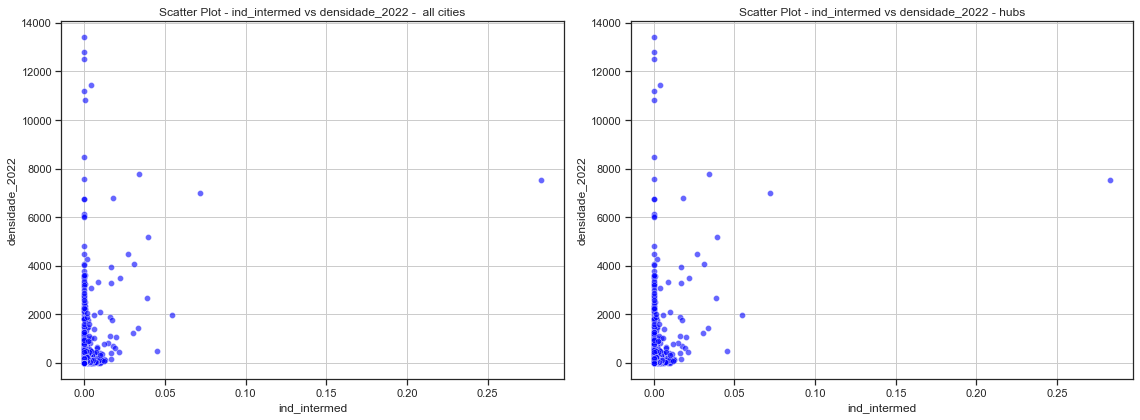

In [354]:
import matplotlib.pyplot as plt
import seaborn as sns
# Definir o estilo do gráfico
sns.set(style="ticks")

# Criar uma nova figura e eixos (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


# Plotar o gráfico de dispersão 1
sns.scatterplot(data=data_all, x='ind_intermed', y='densidade_2022', color='blue', alpha=0.6, ax=axs[0])
axs[0].set_title('Scatter Plot - ind_intermed vs densidade_2022 -  all cities')
axs[0].set_xlabel('ind_intermed')
axs[0].set_ylabel('densidade_2022')
axs[0].grid(True)


# Plotar o gráfico de dispersão 2
sns.scatterplot(data=hub_data, x='ind_intermed', y='densidade_2022', color='blue', alpha=0.6, ax=axs[1])
axs[1].set_title('Scatter Plot - ind_intermed vs densidade_2022 - hubs')
axs[1].set_xlabel('ind_intermed')
axs[1].set_ylabel('densidade_2022')
axs[1].grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os dois gráficos
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nome_UF           5570 non-null   object 
 1   UF2               5570 non-null   int64  
 2   co_ibge           5570 non-null   int64  
 3   Nome_Município    5570 non-null   object 
 4   ind_proxi         5570 non-null   float64
 5   ind_intermed      5570 non-null   float64
 6   ind_proxi_per     5570 non-null   float64
 7   ind_intermed_per  5570 non-null   float64
 8   grau              5570 non-null   float64
 9   densidade_2022    5570 non-null   float64
 10  populacao_2022    5570 non-null   int64  
 11  ones              5570 non-null   int64  
 12  hub_ind_proxi     5570 non-null   float64
 13  hub_ind_intermed  5570 non-null   float64
 14  hub_density       5570 non-null   float64
 15  hub_inter         5570 non-null   float64
dtypes: float64(10), int64(4), object(2)
memory

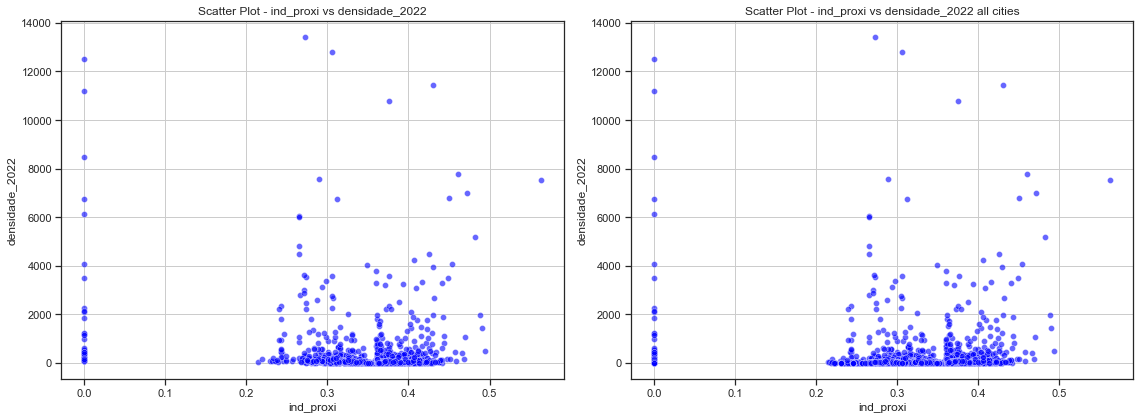

In [373]:
import matplotlib.pyplot as plt
import seaborn as sns
# Definir o estilo do gráfico
sns.set(style="ticks")

# Criar uma nova figura e eixos (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


# Plotar o gráfico de dispersão 1
sns.scatterplot(data=hub_data, x='ind_proxi', y='densidade_2022', color='blue', alpha=0.6, ax=axs[0])
axs[0].set_title('Scatter Plot - ind_proxi vs densidade_2022')
axs[0].set_xlabel('ind_proxi')
axs[0].set_ylabel('densidade_2022')
axs[0].grid(True)


# Plotar o gráfico de dispersão 2
sns.scatterplot(data=data_all, x='ind_proxi', y='densidade_2022', color='blue', alpha=0.6, ax=axs[1])
axs[1].set_title('Scatter Plot - ind_proxi vs densidade_2022 all cities')
axs[1].set_xlabel('ind_proxi')
axs[1].set_ylabel('densidade_2022')
axs[1].grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os dois gráficos
plt.show()

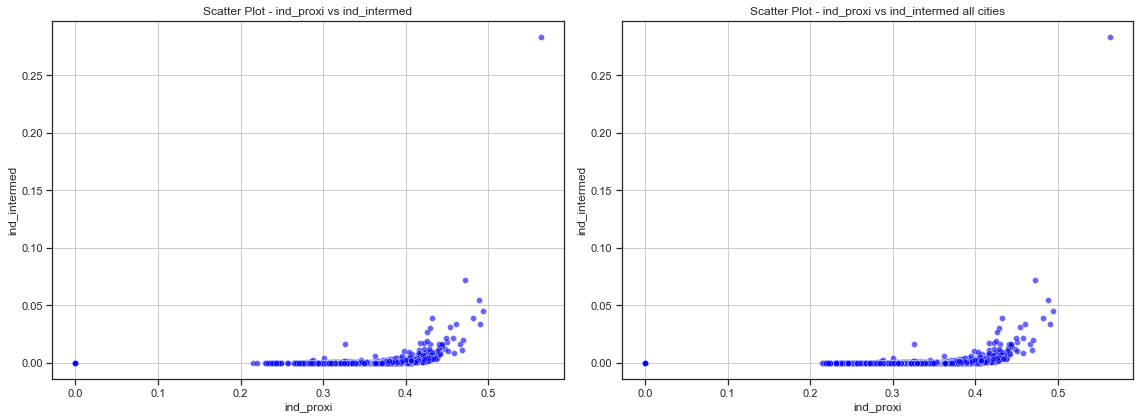

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns
# Definir o estilo do gráfico
sns.set(style="ticks")

# Criar uma nova figura e eixos (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


# Plotar o gráfico de dispersão 1
sns.scatterplot(data=hub_data, x='ind_proxi', y='ind_intermed', color='blue', alpha=0.6, ax=axs[0])
axs[0].set_title('Scatter Plot - ind_proxi vs ind_intermed')
axs[0].set_xlabel('ind_proxi')
axs[0].set_ylabel('ind_intermed')
axs[0].grid(True)


# Plotar o gráfico de dispersão 2
sns.scatterplot(data=data_all, x='ind_proxi', y='ind_intermed', color='blue', alpha=0.6, ax=axs[1])
axs[1].set_title('Scatter Plot - ind_proxi vs ind_intermed all cities')
axs[1].set_xlabel('ind_proxi')
axs[1].set_ylabel('ind_intermed')
axs[1].grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os dois gráficos
plt.show()

In [348]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Definir o estilo do gráfico
# sns.set(style="ticks")

# # Plotar o gráfico de dispersão
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=hub_data, x='ind_proxi', y='densidade_2022', color='blue', alpha=0.6)
# plt.title('Scatter Plot - ind_proxi vs densidade_2022')
# plt.xlabel('ind_proxi')
# plt.ylabel('densidade_2022')
# plt.grid(True)
# plt.show()

In [377]:
#Link = https://www.askpython.com/python/examples/regression-splines
X = hub_data[['ind_proxi']] 
y = hub_data[['densidade_2022']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

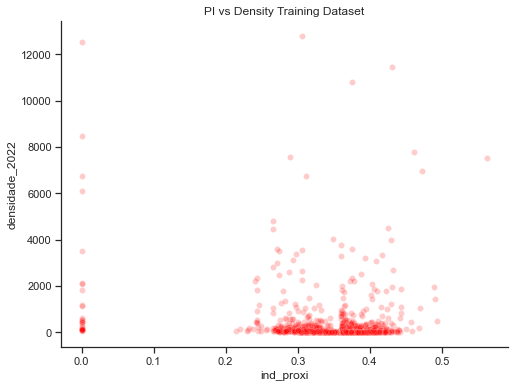

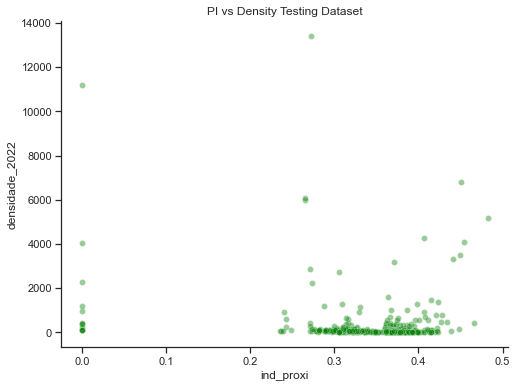

In [378]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train['ind_proxi'], y=y_train['densidade_2022'], color="red",alpha=0.2)
plt.title("PI vs Density Training Dataset")
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_test['ind_proxi'], y=y_test['densidade_2022'], color="green",alpha=0.4)
plt.title("PI vs Density Testing Dataset")
 
plt.show()

In [379]:
X_train.describe()

,ind_proxi
count,2005.000000
mean,0.345854
std,0.058592
min,0.000000
25%,0.315648
50%,0.363295
75%,0.373613
max,0.563410


In [380]:
from patsy import dmatrix
# 25%, 50%, 75%
transformed_x = dmatrix("bs(train, knots=(0.315648,0.363295,0.373613), degree=3, include_intercept=False)",
                        {"train": X_train},return_type='dataframe')

In [381]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
cs = sm.GLM(y_train, transformed_x).fit()
pred_test = cs.predict(dmatrix("bs(test, knots=(0.315648,0.363295,0.373613), include_intercept=False)",
                               {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)
print("Accuracy for Cubic Spline on testing data is : ",rmse_test)

Accuracy for Cubic Spline on testing data is :  979.7606176310363


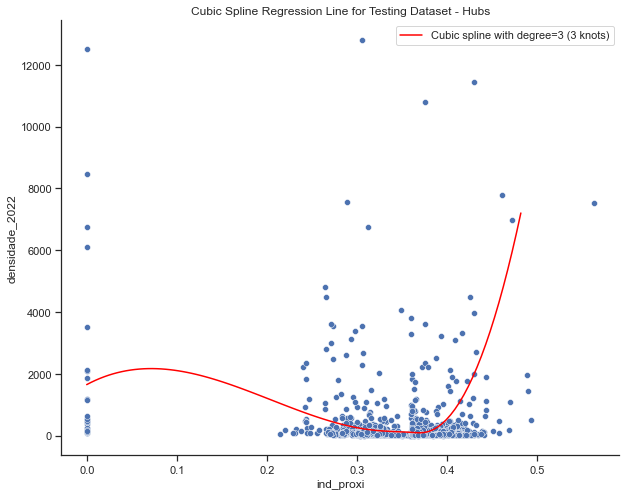

In [382]:
import numpy as np
plt.figure(figsize=(10,8))
xp = np.linspace(X_test.min(),X_test.max(), 100)
pred = cs.predict(dmatrix("bs(xp, knots=(0.315648,0.363295,0.373613), include_intercept=False)", 
                          {"xp": xp}, return_type='dataframe'))
sns.scatterplot(x=X_train['ind_proxi'], y=y_train['densidade_2022']) #x=X_test['ind_proxi'], y=y_test['densidade_2022']
plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='red')
plt.legend()
plt.title("Cubic Spline Regression Line for Testing Dataset - Hubs")
plt.show()

# All cities

In [365]:
#Link = https://www.askpython.com/python/examples/regression-splines
# data['ind_intermed'] >= 0.000053
X = data_all[['ind_proxi']] 
y = data_all[['densidade_2022']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)


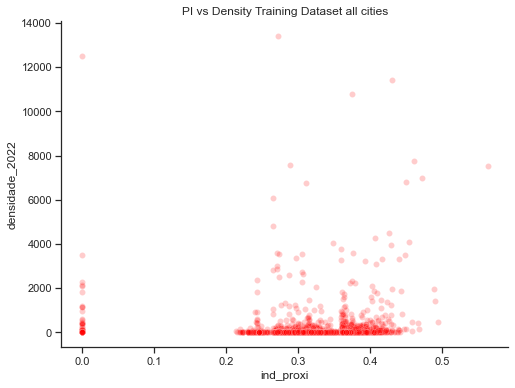

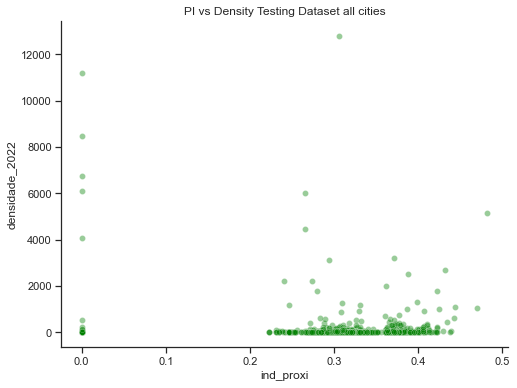

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train['ind_proxi'], y=y_train['densidade_2022'], color="red",alpha=0.2)
plt.title("PI vs Density Training Dataset all cities")
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_test['ind_proxi'], y=y_test['densidade_2022'], color="green",alpha=0.4)
plt.title("PI vs Density Testing Dataset all cities")
 
plt.show()

In [311]:
X_train.describe()

,ind_proxi
count,4456.000000
mean,0.312984
std,0.070445
min,0.000000
25%,0.295167
50%,0.314057
75%,0.361508
max,0.563410


In [367]:
from patsy import dmatrix
transformed_x = dmatrix("bs(train, knots=(0.295167,0.314057,0.361508), degree=3, include_intercept=False)",
                        {"train": X_train},return_type='dataframe')

In [368]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
cs = sm.GLM(y_train, transformed_x).fit()
pred_test = cs.predict(dmatrix("bs(test, knots=(0.295167,0.314057,0.361508), include_intercept=False)",
                               {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)
print("Accuracy for Cubic Spline on testing data is : ",rmse_test)

Accuracy for Cubic Spline on testing data is :  779.2890571018642


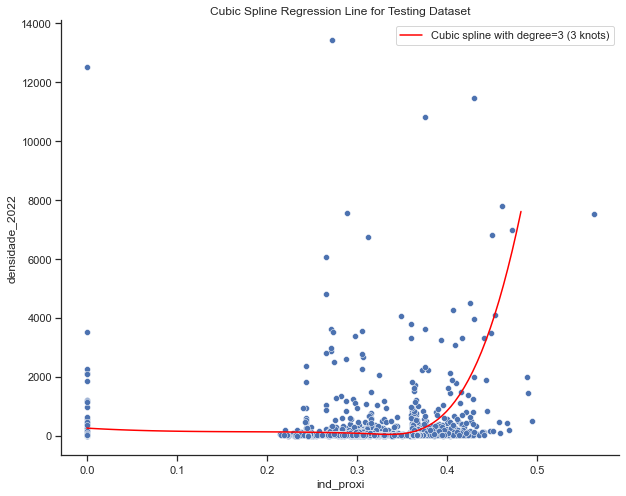

In [369]:
import numpy as np
plt.figure(figsize=(10,8))
xp = np.linspace(X_test.min(),X_test.max(), 100)
pred = cs.predict(dmatrix("bs(xp, knots=(0.295167,0.314057,0.361508), include_intercept=False)", 
                          {"xp": xp}, return_type='dataframe'))
sns.scatterplot(x=X_train['ind_proxi'], y=y_train['densidade_2022']) #x=X_test['ind_proxi'], y=y_test['densidade_2022']
plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='red')
plt.legend()
plt.title("Cubic Spline Regression Line for Testing Dataset all cities")
plt.show()

In [370]:
data.groupby(['Nome_UF','hub_ind_proxi'])['populacao_2022'].sum().reset_index()

,Nome_UF,hub_ind_proxi,populacao_2022
0,Acre,0.0,423921
1,Acre,1.0,406105
2,Alagoas,0.0,1245190
3,Alagoas,1.0,1882321
4,Amapá,0.0,733508
5,Amazonas,0.0,3941175
6,Bahia,0.0,3969842
7,Bahia,1.0,10166575
8,Ceará,0.0,3658441
9,Ceará,1.0,5133247


In [316]:
data.groupby(['Nome_UF','hub_ind_intermed'])['populacao_2022'].sum().reset_index()

,Nome_UF,hub_ind_intermed,populacao_2022
0,Acre,0.0,332033
1,Acre,1.0,497993
2,Alagoas,0.0,1379392
3,Alagoas,1.0,1748119
4,Amapá,0.0,290575
5,Amapá,1.0,442933
6,Amazonas,0.0,1601418
7,Amazonas,1.0,2339757
8,Bahia,0.0,5348181
9,Bahia,1.0,8788236


In [54]:
data.groupby(['Nome_UF','hub_density'])['populacao_2022'].sum().reset_index()



,Nome_UF,hub_density,populacao_2022
0,Acre,0.0,830026
1,Alagoas,0.0,390129
2,Alagoas,1.0,2737382
3,Amapá,0.0,183202
4,Amapá,1.0,550306
5,Amazonas,0.0,1877628
6,Amazonas,1.0,2063547
7,Bahia,0.0,6887979
8,Bahia,1.0,7248438
9,Ceará,0.0,2755230
